In [1]:
from physDBD import ImportHelper, DataDesc, Params0GaussTraj, RxnInputsGaussLayer, \
    DParams0GaussTraj, RxnGaussModel, TrainingGaussData, DataTypeGauss
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle
import matplotlib.pyplot as plt

# Network

In [2]:
data_desc = DataDesc(
    seed_start_inc=0,
    seed_end_exc=25,
    time_start=1,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
)

In [3]:
# Freqs, coffs for fourier
freqs = np.array([1.,2.,3.,4.,5.,6.])
freqs = 2.0 * np.pi * freqs / data_desc.no_times

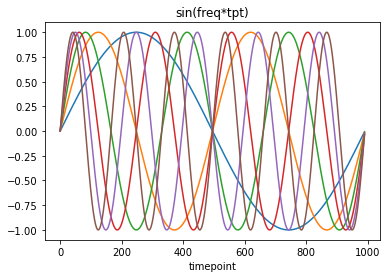

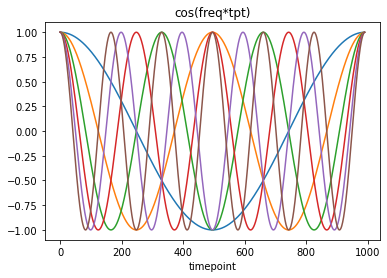

In [4]:
no_tpts = np.arange(0,data_desc.no_times)

plt.figure()
for freq in freqs:
    plt.plot(np.sin(freq * no_tpts))

plt.title("sin(freq*tpt)")
plt.xlabel("timepoint")
plt.savefig("figures/freqs_sin.png", dpi=200)

plt.figure()
for freq in freqs:
    plt.plot(np.cos(freq * no_tpts))

plt.title("cos(freq*tpt)")
plt.xlabel("timepoint")
plt.savefig("figures/freqs_cos.png", dpi=200)

## Reactions

In [5]:
# Rxns
rxn_specs = [
    ("EAT",0,1),
    ("EAT",1,0),
    ("EAT",2,0),
    ("EAT",0,2),
    ("EAT",1,2),
    ("EAT",2,1),
    ("BIRTH",0),
    ("BIRTH",1),
    ("BIRTH",2),
    ("DEATH",0),
    ("DEATH",1),
    ("DEATH",2)
    ]

In [6]:
# Reaction input layer
non_zero_idx_pairs_vv = [(0,0),(1,0),(1,1)]
non_zero_idx_pairs_hv = [(0,0),(0,1)]
non_zero_idx_pairs_hh = [(0,0)]
rxn_lyr = RxnInputsGaussLayer.construct_zero_init(
    nv=2,
    nh=1,
    freqs=freqs,
    non_zero_idx_pairs_vv=non_zero_idx_pairs_vv,
    non_zero_idx_pairs_hv=non_zero_idx_pairs_hv,
    non_zero_idx_pairs_hh=non_zero_idx_pairs_hh,
    rxn_specs=rxn_specs
    )

## Subnet

In [39]:
# Shallow
'''
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1.)),
    tf.keras.layers.Dropout(0.5)
])
'''

"\nsubnet = tf.keras.Sequential([\n    tf.keras.layers.Dense(25, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1.)),\n    tf.keras.layers.Dropout(0.5)\n])\n"

In [48]:
# Deep
'''
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3)
])
'''

subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(),
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(),
    tf.keras.layers.Dense(100, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU()
])

## Model

In [49]:
model = RxnGaussModel.construct(
    nv=2,
    nh=1,
    rxn_lyr=rxn_lyr,
    subnet=subnet
    )

## Training data

In [50]:
td = TrainingGaussData()

# Import
params0_filtered_traj = Params0GaussTraj.fromFile("cache/cache_params_filtered.txt", nv=2)
params0_norm_deriv_norm_traj = DParams0GaussTraj.fromFile("cache/cache_params_norm_deriv_norm.txt", nv=2)

pt = int(0.5*params0_filtered_traj.nt)

# Training data
td.reap_params0_traj_for_inputs(
    params0_traj=params0_filtered_traj, 
    tpt_start_inc=0,
    tpt_end_exc=pt,
    data_type=DataTypeGauss.TRAINING, 
    non_zero_idx_pairs_vv=non_zero_idx_pairs_vv
    )
td.reap_dparams0_traj_for_outputs(
    dparams0_traj=params0_norm_deriv_norm_traj, 
    tpt_start_inc=0,
    tpt_end_exc=pt,
    data_type=DataTypeGauss.TRAINING
    )
td.reap_params0_traj_for_inputs(
    params0_traj=params0_filtered_traj, 
    tpt_start_inc=pt,
    tpt_end_exc=params0_filtered_traj.nt-1, # Take off one to match derivs
    data_type=DataTypeGauss.VALIDATION, 
    non_zero_idx_pairs_vv=non_zero_idx_pairs_vv
    )
td.reap_dparams0_traj_for_outputs(
    dparams0_traj=params0_norm_deriv_norm_traj, 
    tpt_start_inc=pt,
    tpt_end_exc=params0_norm_deriv_norm_traj.nt,
    data_type=DataTypeGauss.VALIDATION
    )

In [51]:
# Normalize inputs

# Reaction layer to use for the normalization
rxn_lyr_norm = RxnInputsGaussLayer.construct_one_init(
    nv=2,
    nh=1,
    freqs=np.array([freqs[-1]]),
    non_zero_idx_pairs_vv=non_zero_idx_pairs_vv,
    non_zero_idx_pairs_hv=non_zero_idx_pairs_hv,
    non_zero_idx_pairs_hh=non_zero_idx_pairs_hh,
    rxn_specs=rxn_specs
    )

# Normalize inputs
model.calculate_rxn_normalization(
    rxn_lyr=rxn_lyr_norm, 
    inputs=td.train_inputs, 
    percent=0.2
    )

Calculating input normalization from: 99 samples


In [52]:
print("Reaction normalization: Mean: ", model.rxn_mean)
print("Reaction normalization: Std dev: ", model.rxn_std_dev)

Reaction normalization: Mean:  [-4.4546537e+00 -2.1715229e+01  1.0795841e+02  3.3148108e+06
 -3.3148108e+06  1.8777049e+00  4.6156734e+01 -1.3068523e+02
 -3.3148108e+06  3.3148108e+06  2.7046073e-03  1.3929163e+00
  1.9433309e-04 -1.1349432e+03  0.0000000e+00 -4.7602658e-03
 -1.3927563e+00 -5.3997850e-04  1.1349420e+03  0.0000000e+00
  5.1341856e-05  2.7451407e-02 -9.4052173e-02  0.0000000e+00
  1.0305071e+03 -1.3163421e-04 -2.6078707e-02  9.0824611e-02
  0.0000000e+00 -1.0305068e+03 -6.3996417e-03  8.9682412e-04
  0.0000000e+00  6.1078164e+03  0.0000000e+00 -3.3943001e-05
  2.9402035e-03 -1.8821431e-02  0.0000000e+00  4.9128180e+02
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  3.8726004e-03  8.9670072e-04  0.0000000e+00
 -6.1078164e+03  0.0000000e+00 -3.3941604e-05 -1.8563500e-03
  1.6200060e-02  0.0000000e+00 -4.9128180e+02  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
Reaction normalization: Std dev:  [6.61999416e+00 5.2

# Train

In [54]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=loss_fn,
              run_eagerly=False)

# Log outputs for tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
    histogram_freq=1,
    write_graph=False
    )

# Write weights of lowest validation score
val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained/weights_lowest_val', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='auto', 
    save_frequency=1
    )

# Train!
model.fit(
    td.train_inputs, 
    td.train_outputs_not_stdrd, 
    validation_data=(td.valid_inputs,td.valid_outputs_not_stdrd),
    epochs=50, 
    # callbacks=[tensorboard_callback,val_checkpoint],
    callbacks=[tensorboard_callback],
    batch_size=16
)

# Save
model.save("trained/trained_final", save_traces=False)

Epoch 1/50
31/31 [==============================] - 78s 616ms/step - loss: 0.0485 - dchol_v_0_0_loss: 0.0057 - dchol_v_1_0_loss: 0.0036 - dchol_v_1_1_loss: 0.0044 - dmu_v_0_loss: 0.0139 - dmu_v_1_loss: 0.0208 - val_loss: 1.0379 - val_dchol_v_0_0_loss: 0.0599 - val_dchol_v_1_0_loss: 0.4917 - val_dchol_v_1_1_loss: 0.1050 - val_dmu_v_0_loss: 0.0367 - val_dmu_v_1_loss: 0.3447
Epoch 2/50
31/31 [==============================] - 1s 45ms/step - loss: 0.0157 - dchol_v_0_0_loss: 0.0031 - dchol_v_1_0_loss: 0.0037 - dchol_v_1_1_loss: 0.0032 - dmu_v_0_loss: 0.0021 - dmu_v_1_loss: 0.0037 - val_loss: 0.9428 - val_dchol_v_0_0_loss: 0.0532 - val_dchol_v_1_0_loss: 0.4322 - val_dchol_v_1_1_loss: 0.1059 - val_dmu_v_0_loss: 0.0437 - val_dmu_v_1_loss: 0.3077
Epoch 3/50
31/31 [==============================] - 1s 46ms/step - loss: 0.0103 - dchol_v_0_0_loss: 0.0015 - dchol_v_1_0_loss: 0.0021 - dchol_v_1_1_loss: 0.0022 - dmu_v_0_loss: 8.6148e-04 - dmu_v_1_loss: 0.0036 - val_loss: 0.9601 - val_dchol_v_0_0_loss